## Data augmentation

In [ ]:
import keras
from keras import layers
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tqdm.notebook import tqdm
import os
os.getcwd()

'/content'

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for b in bird_types:
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    img=mpimg.imread(mypath + f)
    x = img_to_array(img) 
    x = x.reshape((1,) + x.shape) 
    i = 0
    for batch in datagen.flow(x, batch_size=1, 
                              save_to_dir='./gdrive/My Drive/birds_aug/' + b + "/", 
                              save_prefix='', 
                              save_format='jpeg'):
        i += 1
        if i > 20:
            break  

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [ ]:
# Core layers
from keras.layers import Activation, Dropout, Flatten, Dense, Input, LeakyReLU, BatchNormalization, concatenate, multiply, Embedding
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD

In [ ]:
latent_dim = 100 # dimension of the latent space
n_samples = 1000 # size of our dataset
n_classes = 3
n_features = 2 # we use 2 features since we'd like to visualize them

In [ ]:
def build_discriminator(optimizer=Adam(0.0002, 0.5)):
    '''
    Defines and compiles discriminator model.
    This architecture has been inspired by:
    https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
    and adapted for this problem.
    
    Params:
        optimizer=Adam(0.0002, 0.5) - recommended values
    '''
    features = Input(shape=(n_features,))
    label = Input(shape=(1,), dtype='int32')
    
    # Using an Embedding layer is recommended by the papers
    label_embedding = Flatten()(Embedding(n_classes, n_features)(label))
    
    # We condition the discrimination of generated features 
    inputs = multiply([features, label_embedding])
    
    x = Dense(512)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    model = Model([features, label], valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
def build_generator():
    '''
    Defines the generator model.
    This architecture has been inspired by:
    https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
    and adapted for this problem.
    '''
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    # Using an Embedding layer is recommended by the papers
    label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))
    
    # We condition the generation of features
    inputs = multiply([noise, label_embedding])
    
    x = Dense(256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    features = Dense(n_features, activation='tanh')(x)
    
    model = Model([noise, label], features)
    model.summary()

    return model

In [ ]:
def build_gan(generator, discriminator, optimizer=Adam(0.0002, 0.5)):
    '''
    Defines and compiles GAN model. It bassically chains Generator
    and Discriminator in an assembly-line sort of way where the input is
    the Generator's input. The Generator's output is the input of the Discriminator,
    which outputs the output of the whole GAN.
    
    Params:
        optimizer=Adam(0.0002, 0.5) - recommended values
    '''
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    
    features = generator([noise, label])
    valid = discriminator([features, label])
    
    # We freeze the discriminator's layers since we're only 
    # interested in the generator and its learning
    discriminator.trainable = False
    
    model = Model([noise, label], valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
discriminator = build_discriminator()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 2)         6           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2)            0           embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
generator = build_generator()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       300         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_1[0][0]                
_______________________________________________________________________________________

In [ ]:
gan = build_gan(generator, discriminator)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 2)            692270      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1)            527367      functional_3[0][0]    

In [ ]:
def get_random_batch(X, y, batch_size):
    '''
    Will return random batches of size batch_size
    
    Params:
        X: numpy array - features
        y: numpy array - classes
        batch_size: Int
    '''
    idx = np.random.randint(0, len(X))
    
    X_batch = X[idx:idx+batch_size]
    y_batch = y[idx:idx+batch_size]
    
    return X_batch, y_batch

In [ ]:
def train_gan(gan, generator, discriminator, 
              X, y, 
              n_epochs=1000, batch_size=32, 
              hist_every=10, log_every=100):
    '''
    Trains discriminator and generator (last one through the GAN) 
    separately in batches of size batch_size. The training goes as follow:
        1. Discriminator is trained with real features from our training data
        2. Discriminator is trained with fake features generated by the Generator
        3. GAN is trained, which will only change the Generator's weights.
        
    Params:
        gan: GAN model
        generator: Generator model
        discriminator: Discriminator model
        X: numpy array - features
        y: numpy array - classes
        n_epochs: Int
        batch_size: Int
        hist_every: Int - will save the training loss and accuracy every hist_every epochs
        log_every: Int - will output the loss and accuracy every log_every epochs
    
    Returns:
        loss_real_hist: List of Floats
        acc_real_hist: List of Floats
        loss_fake_hist: List of Floats
        acc_fake_hist: List of Floats
        loss_gan_hist: List of Floats
        acc_gan_hist: List of Floats
    '''
    
    half_batch = int(batch_size / 2)
    
    acc_real_hist = []
    acc_fake_hist = []
    acc_gan_hist = []
    loss_real_hist = []
    loss_fake_hist = []
    loss_gan_hist = []
    
    for epoch in range(n_epochs):
        
        X_batch, labels = get_random_batch(X, y, batch_size)
        
        # train with real values
        y_real = np.ones((X_batch.shape[0], 1))
        loss_real, acc_real = discriminator.train_on_batch([X_batch, labels], y_real)
        
        # train with fake values
        noise = np.random.uniform(0, 1, (labels.shape[0], latent_dim))
        X_fake = generator.predict([noise, labels])
        y_fake = np.zeros((X_fake.shape[0], 1))
        loss_fake, acc_fake = discriminator.train_on_batch([X_fake, labels], y_fake)
        
        y_gan = np.ones((labels.shape[0], 1))
        loss_gan, acc_gan = gan.train_on_batch([noise, labels], y_gan)
        
        if (epoch+1) % hist_every == 0:
            acc_real_hist.append(acc_real)
            acc_fake_hist.append(acc_fake)
            acc_gan_hist.append(acc_gan)
            loss_real_hist.append(loss_real)
            loss_fake_hist.append(loss_fake)
            loss_gan_hist.append(loss_gan)

        if (epoch+1) % log_every == 0:
            lr = 'loss real: {:.3f}'.format(loss_real)
            ar = 'acc real: {:.3f}'.format(acc_real)
            lf = 'loss fake: {:.3f}'.format(loss_fake)
            af = 'acc fake: {:.3f}'.format(acc_fake)
            lg = 'loss gan: {:.3f}'.format(loss_gan)
            ag = 'acc gan: {:.3f}'.format(acc_gan)

            print('{}, {} | {}, {} | {}, {}'.format(lr, ar, lf, af, lg, ag))
        
    return loss_real_hist, acc_real_hist, loss_fake_hist, acc_fake_hist, loss_gan_hist, acc_gan_hist

In [ ]:
X_train = []
y_train = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/train/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    x = mpimg.imread(mypath + f) / 255.
    X_train.append(x)
    y_train.append(i)

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train).reshape(-1,1)

In [ ]:
print(X_train.shape, y_train.shape)

(1526, 224, 224, 3) (1526, 1)


In [ ]:
X_valid = []
y_valid = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/valid/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    x = mpimg.imread(mypath + f) / 255.
    X_valid.append(x)
    y_valid.append(i)

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [ ]:
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid).reshape(-1,1)

In [ ]:
print(X_valid.shape, y_valid.shape)

(50, 224, 224, 3) (50, 1)


In [ ]:
X_test = []
y_test = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds/test/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in tqdm(onlyfiles):
    x = mpimg.imread(mypath + f) / 255.
    X_test.append(x)
    y_test.append(i)

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [ ]:
X_test = np.asarray(X_test)
y_test = np.asarray(y_test).reshape(-1,1)

In [ ]:
print(X_test.shape, y_test.shape)

(50, 224, 224, 3) (50, 1)


## CNN 10 classes without augmentation

In [ ]:
input_img = keras.Input(shape=(224, 224, 3))

# first CNN layer
x = layers.Conv2D(filters = 32, kernel_size=2, strides=2, 
                      padding="valid", activation='relu', input_shape=(32, 32, 3))(input_img)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
# second CNN layer
x = layers.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
# third CNN layer
x = layers.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')(x)
x = layers.MaxPool2D(pool_size=2, padding="same")(x)
x = layers.Dropout(0.2)(x)
# dense
x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(10, activation='sigmoid')(x)
cnn = keras.Model(input_img, x)
cnn.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 16)        2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 27, 16)       

In [ ]:
from keras.utils.np_utils import to_categorical   
y_train_cat = to_categorical(y_train, num_classes=10)
y_valid_cat = to_categorical(y_valid, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [ ]:
from keras.callbacks import TensorBoard
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
results = cnn.fit(X_train, y_train_cat,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_valid, y_valid_cat),
                callbacks=[TensorBoard(log_dir='./anly590_final_project/tmp/cnn')])

Epoch 1/20
 1/12 [=>............................] - ETA: 0s - loss: 2.3518 - accuracy: 0.0938WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
12/12 [==============================] - 13s 1s/step - loss: 2.3271 - accuracy: 0.0865 - val_loss: 2.3073 - val_accuracy: 0.1400
Epoch 2/20
12/12 [==============================] - 12s 1s/step - loss: 2.3076 - accuracy: 0.1029 - val_loss: 2.3039 - val_accuracy: 0.1200
Epoch 3/20
12/12 [==============================] - 13s 1s/step - loss: 2.3000 - accuracy: 0.1062 - val_loss: 2.3025 - val_accuracy: 0.0800
Epoch 4/20
12/12 [==============================] - 12s 1s/step - loss: 2.2975 - accuracy: 0.1140 - val_loss: 2.3021 - val_accuracy: 0.1000
Epoch 5/20
12/12 [==============================] - 13s 1s/step - loss: 2.2920 -

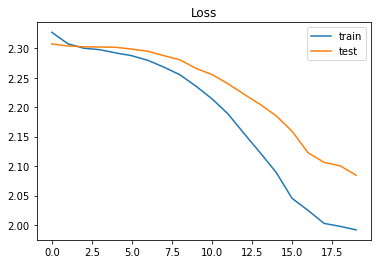

In [ ]:
plt.title('Loss')
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='test')
plt.legend()
plt.show()

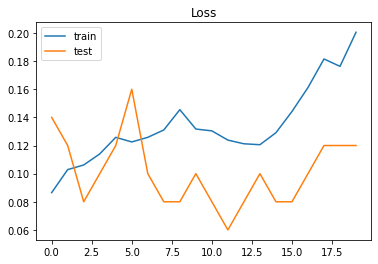

In [ ]:
plt.title('Loss')
plt.plot(results.history['accuracy'], label='train')
plt.plot(results.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
prediction = cnn.predict(np.array(X_test))

In [ ]:
pred_class = [np.argmax(e) for e in prediction]

Confusion matrix, without normalization


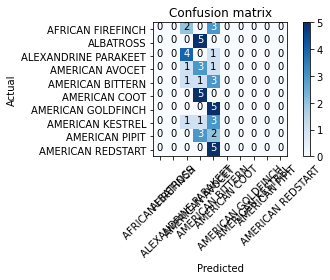

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

cm = confusion_matrix(y_test.reshape(-1), pred_class)
plot_confusion_matrix(cm, classes = bird_types)

In [ ]:
cnn.save("./gdrive/My Drive/cnn")
json_config = cnn.to_json()
with open("./gdrive/My Drive/cnn/cnn_model_config.json", "w") as json_file:
    json_file.write(json_config)
# serialize weights to HDF5
cnn.save_weights("./gdrive/My Drive/cnn/cnn_model.h5")

INFO:tensorflow:Assets written to: ./gdrive/My Drive/cnn/assets


## CNN with augmentation

In [ ]:
from random import sample

In [ ]:
X_train = []
y_train = []
bird_types = ['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 
              'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART']
for i, b in enumerate(bird_types):
  print("Bird type:", b)
  mypath = './gdrive/My Drive/birds_aug/train/' + b + "/"
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  samp = sample(onlyfiles, 500)
  for f in tqdm(samp):
    x = mpimg.imread(mypath + f) / 255.
    X_train.append(x)
    y_train.append(i)

Bird type: AFRICAN FIREFINCH



Bird type: ALBATROSS



Bird type: ALEXANDRINE PARAKEET



Bird type: AMERICAN AVOCET



Bird type: AMERICAN BITTERN



Bird type: AMERICAN COOT



Bird type: AMERICAN GOLDFINCH



Bird type: AMERICAN KESTREL



Bird type: AMERICAN PIPIT



Bird type: AMERICAN REDSTART


In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train).reshape(-1,1)

In [ ]:
print(X_train.shape, y_train.shape)

(5000, 224, 224, 3) (5000, 1)


In [ ]:
from keras.utils.np_utils import to_categorical   
y_train_cat = to_categorical(y_train, num_classes=10)

In [ ]:
input_img = keras.Input(shape=(224, 224, 3))

# first CNN layer
x = layers.Conv2D(filters = 32, kernel_size=2, strides=2, 
                      padding="valid", activation='relu', input_shape=(32, 32, 3))(input_img)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
# second CNN layer
x = layers.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
# third CNN layer
x = layers.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')(x)
x = layers.MaxPool2D(pool_size=2, padding="same")(x)
x = layers.Dropout(0.2)(x)
# dense
x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(10, activation='sigmoid')(x)
cnn2 = keras.Model(input_img, x)
cnn2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 16)        2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 16)       

In [ ]:
from keras.callbacks import TensorBoard
cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
results2 = cnn2.fit(X_train, y_train_cat,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_valid, y_valid_cat),
                callbacks=[TensorBoard(log_dir='./anly590_final_project/tmp/cnn')])

Epoch 1/20
 1/40 [..............................] - ETA: 0s - loss: 2.3149 - accuracy: 0.1406WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
40/40 [==============================] - 44s 1s/step - loss: 2.3039 - accuracy: 0.1272 - val_loss: 2.2972 - val_accuracy: 0.1200
Epoch 2/20
40/40 [==============================] - 43s 1s/step - loss: 2.2781 - accuracy: 0.1766 - val_loss: 2.2792 - val_accuracy: 0.2000
Epoch 3/20
40/40 [==============================] - 43s 1s/step - loss: 2.2301 - accuracy: 0.2030 - val_loss: 2.2212 - val_accuracy: 0.2200
Epoch 4/20
40/40 [==============================] - 43s 1s/step - loss: 2.1232 - accuracy: 0.2428 - val_loss: 2.0928 - val_accuracy: 0.2000
Epoch 5/20
40/40 [==============================] - 43s 1s/step - loss: 1.9461 -

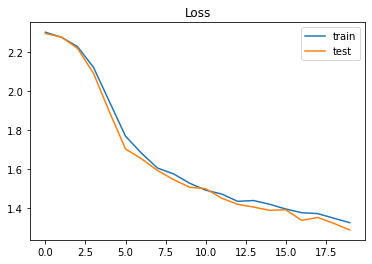

In [ ]:
plt.title('Loss')
plt.plot(results2.history['loss'], label='train')
plt.plot(results2.history['val_loss'], label='test')
plt.legend()
plt.show()

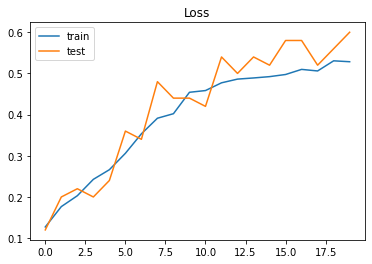

In [ ]:
plt.title('Loss')
plt.plot(results2.history['accuracy'], label='train')
plt.plot(results2.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
prediction2 = cnn2.predict(np.array(X_test))
pred_class2 = [np.argmax(e) for e in prediction2]

Confusion matrix, without normalization


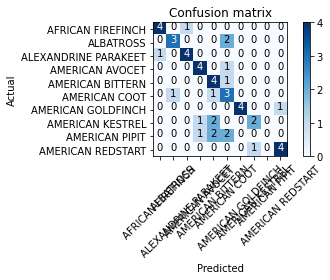

In [ ]:
cm = confusion_matrix(y_test.reshape(-1), pred_class2)
plot_confusion_matrix(cm, classes = bird_types)

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
cnn2.save("./gdrive/My Drive/cnn2")

INFO:tensorflow:Assets written to: ./gdrive/My Drive/cnn2/assets


In [ ]:
json_config = cnn2.to_json()

In [ ]:
with open("./gdrive/My Drive/cnn2/cnn2_model_config.json", "w") as json_file:
    json_file.write(json_config)
# serialize weights to HDF5
cnn2.save_weights("./gdrive/My Drive/cnn2/cnn2_model.h5")

## Model explainability

In [ ]:
X_train.shape

(1526, 224, 224, 3)

In [ ]:
X_train[0].shape

(224, 224, 3)

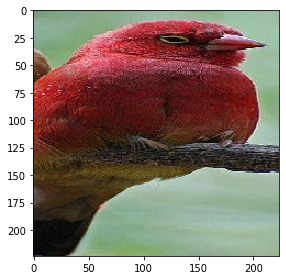

In [ ]:
import skimage
import skimage.io
skimage.io.imshow(X_train[0])

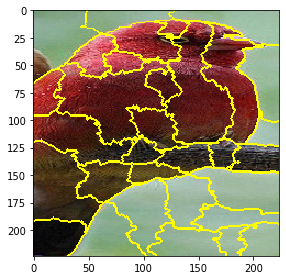

In [ ]:
#Generate segmentation for image
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(X_train[0], kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(X_train[0], superpixels))

[0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0]


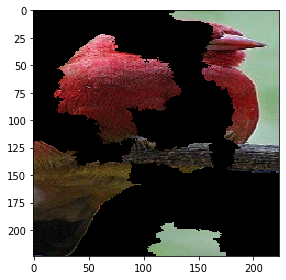

In [ ]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(X_train[0],perturbations[0],superpixels))

In [ ]:
from tensorflow import keras
cnn2 = keras.models.load_model('./gdrive/My Drive/cnn2')

In [ ]:
cnn2

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(X_train[0],pert,superpixels)
  pred = cnn2.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 10)


In [ ]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

(150,)


In [ ]:
#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)


In [ ]:
preds = cnn2.predict(X_train[0][np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes

In [ ]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0] 
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

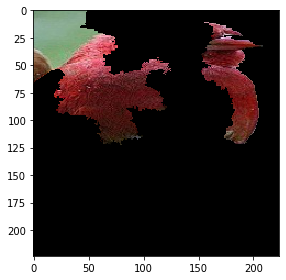

In [ ]:
#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(X_train[0],mask,superpixels))

## SHAP

In [ ]:
pip install shap

     |████████████████████████████████| 327kB 11.6MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463909 sha256=542ed2bd6fb73797ed4fb2ca5640befe8d1c1f56b5392058683261707d696754
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
import math
from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import shap

from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap
from keras.engine.training import Model

In [ ]:
def mask_image(
    zs: np.array, 
    segmentation: np.array, 
    image: np.array, 
    background: Optional[int] = None
) -> np.array:
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

In [ ]:
def fill_segmentation(values: np.array, segmentation_lut: np.array) -> np.array:
    out = np.zeros(segmentation_lut.shape)
    for i in range(values.shape[0]):
        out[segmentation_lut == i] = values[i]
    return out

In [ ]:
def get_colormap() -> LinearSegmentedColormap:
    blue = (22/255, 134/255, 229/255)
    blue_shades = [(*blue, alpha) for alpha in np.linspace(1, 0, 100)]
    red = (254/255 ,0/255, 86/255)
    red_shades = [(*red, alpha) for alpha in np.linspace(0, 1, 100)]
    return LinearSegmentedColormap.from_list("shap", blue_shades + red_shades)

In [ ]:
def plot_shap_top_explanations(
    model, 
    image, 
    class_names,
    #class_names_mapping: Dict[int, str],
    top_preds_count = 3,
    fig_title = None,
    fig_name = None
) -> None:
    """
    A method that provides explanations for N top classes.
    :param model: Keras based Image Classification model
    :param image: Single image in the form of numpy array. Shape: [224, 224, 3]
    #:param class_names_mapping: Dictionary that provides mapping between class inedex and name
    :param top_preds_count: Number of top predictions that we want to explain
    :param fig_title: Figure title
    :param fig_name: Output figure path
    :return:
    """
    
    image_columns = 3
    image_rows = math.ceil(top_preds_count / image_columns)
    
    segments_slic = slic(image, n_segments=100, compactness=2, sigma=3)
    
    def _h(z):
        return model.predict(mask_image(z, segments_slic, image, 255))
    
    explainer = shap.KernelExplainer(_h, np.zeros((1,100)))
    shap_values = explainer.shap_values(np.ones((1,100)), nsamples=1000)
    
    preds = model.predict(np.expand_dims(image, axis=0))
    top_preds_indexes = np.flip(np.argsort(preds))[0,:top_preds_count]
    top_preds_values = preds.take(top_preds_indexes)
    top_preds_names = np.vectorize(lambda x: class_names[x])(top_preds_indexes)
    
    plt.style.use('ggplot')
    fig, axes = plt.subplots(image_rows, image_columns, figsize=(image_columns * 5, image_rows * 5))
    [ax.set_axis_off() for ax in axes.flat]
    
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    color_map = get_colormap()
    
    for i, (index, value, name, ax) in \
        enumerate(zip(top_preds_indexes, top_preds_values, top_preds_names, axes.flat)):
    
        m = fill_segmentation(shap_values[index][0]*50, segments_slic)
        subplot_title = "{}. class: {} pred: {:.3f}".format(i + 1, name, value)
        ax.imshow(image)
        ax.imshow(m, cmap=color_map, vmin=-max_val, vmax=max_val)
        ax.set_title(subplot_title, pad=20)
       
    if fig_title:
        fig.suptitle(fig_title, fontsize=30)
    if fig_name:
        plt.savefig(fig_name)
    plt.show()
    return shap_values

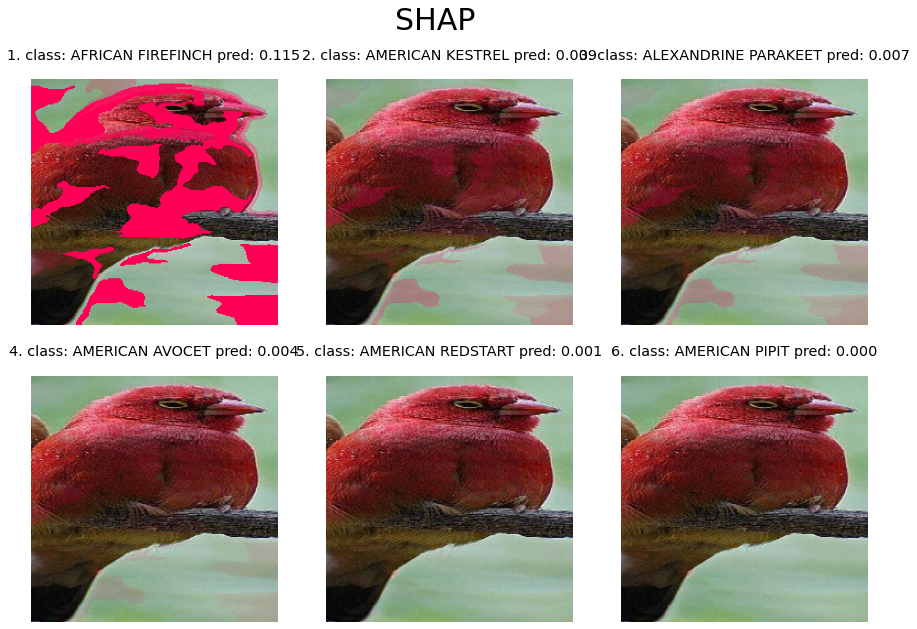

In [ ]:
shap_values = plot_shap_top_explanations(cnn2, X_train[0], bird_types, top_preds_count=6, fig_title="SHAP", fig_name="./gdrive/My Drive/shap_bird.png")

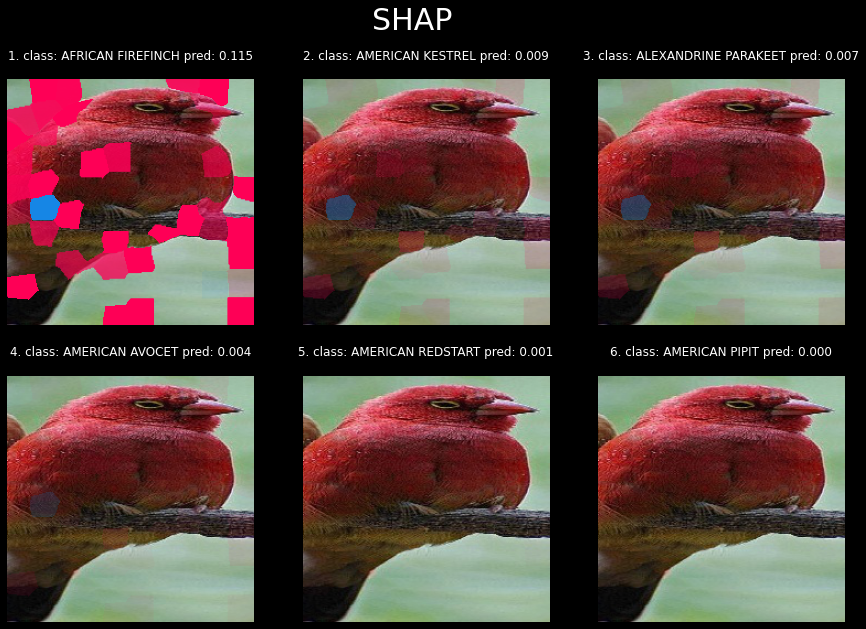

In [ ]:
# compactness = 30
shap_values = plot_shap_top_explanations(cnn2, X_train[0], bird_types, top_preds_count=6, fig_title="SHAP", fig_name="./gdrive/My Drive/shap_bird.png")